In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy import stats

In [3]:
#Classes, Methods, and Functions

def read_csv_to_dataframe(file_path):
    """
    Read a CSV file from the specified file path into a pandas DataFrame.
    Parse the 'Date' column into datetime and set it as the index of the DataFrame.

    :param file_path: str, the path to the CSV file to be read.
    :return: pd.DataFrame, the DataFrame containing the data from the CSV file with the 'Date' column as the index.
    """
    try:
        # Read the CSV file, parsing the 'Date' column as datetime type
        df = pd.read_csv(file_path, parse_dates=['Date'])

        # Set the 'Date' column as the index of the DataFrame
        df.set_index('Date', inplace=True)

        return df
    except Exception as e:
        print(f"An error occurred while reading the CSV file: {e}")
        return None

class UNIXDataProcessor:
    "Converst a df after a json request on market_chart done from the geckoaAPI"
    def __init__(self, df):
        self.df = df
    
    def process(self):
        timestamps = []
        prices = []
        market_caps = []
        total_volumes = []
        
        for _, row in self.df.iterrows():
            timestamps.append(datetime.datetime.fromtimestamp(row['prices'][0]/1000.0))
            prices.append(row['prices'][1])
            market_caps.append(row['market_caps'][1])
            total_volumes.append(row['total_volumes'][1])
        new_df = pd.DataFrame({
            'prices': prices,
            'market_caps': market_caps,
            'toal_volumes' : total_volumes
        },index=timestamps)

        new_df.index.name = 'Datetime'
        return new_df
    
class ReturnCalculator:
    "Transforms a time series of prices into a timeseries of returns"
    def __init__(self, df):
        self.df = df

    def calculate_returns(self, columns):
        if not all(col in self.df for col in columns):
            missing = list(filter(lambda col: col not in self.df, columns))
            raise ValueError(f"Columns not found in DataFrame: {missing}")
        
        returns = np.log(self.df[columns] / self.df[columns].shift(1))

        returns = returns.dropna()

        return returns
    
class Metrics:
    """Gets a set of important charactersitcs in a returns timeseries"""
    def __init__(self,returns):
        #Initializing general parameters used in a couple of the methods
        self.returns= returns
        self.annual_factor = 252
        self.vol_rolling_window = 30

    def annualized_mean_return(self):
        mean_log_return = self.returns.mean()
        annualized_simple_return = (np.exp(mean_log_return) - 1) * self.annual_factor
        return annualized_simple_return

    def mean_return(self):
        mean_log_return = self.returns.mean()
        simple_return = (np.exp(mean_log_return) - 1)
        return simple_return
    
    def cumulative_return(self):
        
        cumulative_return = np.exp(self.returns.sum()) - 1
        return cumulative_return
    
    def volatility(self):
        """
        Calculatesd the monthly volatility over the sample
        """
        rolling_vol = self.returns.rolling(window=self.vol_rolling_window).std()

        return rolling_vol

    def annualized_volatility(self):
        """
        Calculate rolling annualized volatility based on a 5 day window
        """ 
        rolling_vol = self.returns.rolling(window=self.vol_rolling_window).std()

        annualized_vol = rolling_vol * np.sqrt(self.annual_factor)

        return annualized_vol.mean()
    
    def serial_correlation(self, lag=1):
        """
        Calculate the serial correlation of returns at a specified lag.
        :param lag: The lag at which to calculate the serial correlation.
        """
        return self.returns.autocorr(lag)
    
    def rolling_drawdown(self, rolling_window=5, max_drawdown=False):
        """
        Calculate the rolling drawdown or maximum drawdown over a specified window.
        :param rolling_window: The number of periods to consider for each rolling calculation.
        :param max_drawdown: If True, return the maximum drawdown over the window instead of the rolling drawdown.
        """
        # Calculate cumulative returns
        cumulative_returns = (1 + self.returns).cumprod()

        # Calculate the rolling maximum of the cumulative returns
        rolling_max = cumulative_returns.rolling(window=rolling_window, min_periods=1).max()

        # Calculate the rolling drawdown
        rolling_drawdown = (cumulative_returns - rolling_max) / rolling_max

        if max_drawdown:
            # Return the maximum drawdown within each window
            return rolling_drawdown.rolling(window=rolling_window, min_periods=1).min()
        else:
            # Return the rolling drawdown series
            return rolling_drawdown

    def sharpe_ratio(self, risk_free_rate=0.01):
        """
        Calculate the Sharpe Ratio for the asset using the already defined methods for annualized returns and volatility.
        :param risk_free_rate: The risk-free rate of return, default is 1% (0.01)

        NOTE: this method assumes that the time series we are using is exactly one years' length
        otherwise use annualized sharpe ratio method (below)
        """
        # Use the existing methods to calculate annualized mean return and volatility
        ret = self.mean_return()
        vol = self.volatility()

        # Calculate the Sharpe Ratio
        sharpe_ratio = (ret - risk_free_rate) / vol

        return sharpe_ratio

    
    def plot_cumulative_returns(self):
        """
        Plot the returns time series.
        """
        self.cumulative_return().plot(title="Cumulative Returns")
        plt.show()

    def plot_returns(self):
        """
        Plot the returns time series.
        """
        plt.figure(figsize=(12, 6))
        plt.plot(self.returns)
        plt.title("Returns Over Time")
        plt.xlabel("Date")
        plt.ylabel("Returns")
        plt.grid(True)
        plt.show()

    def plot_volatility(self):
        """
        Plot the rolling annualized volatility over a 5-day window.
        """
        # Plotting
        self.annualized_volatility().plot(title="Average 30 month Annualized Volatility ")
        plt.show()

    def plot_return_distribution(self):
        """
        Plot the distribution of returns and compare with a Student's t-distribution.
        """
        mean_return = self.returns.mean()
        std_return = self.returns.std()
    
        # Histogram of returns
        self.returns.hist(bins=50, alpha=0.6, density=True, label='Empirical')

        # Student's t-distribution for comparison
        df, loc, scale = stats.t.fit(self.returns)  # Fit the t-distribution to the returns
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = stats.t.pdf(x, df, loc, scale)
        plt.plot(x, p, 'k', linewidth=2, label="Student's t-Distribution")

        # Final plot adjustments
        plt.title("Returns Distribution with Student's t-Distribution Comparison")
        plt.xlabel("Returns")
        plt.ylabel("Density")
        plt.legend()
        plt.show()

    def plot_volatility_distribution(self):
        """
        Plot the distribution of annualized volatility.
        """
        # Calculate rolling standard deviation (volatility)
        rolling_vol = self.returns.rolling(window=self.vol_rolling_window).std()
    
        # Annualize the volatility
        annualized_vol = rolling_vol * np.sqrt(self.annual_factor)
    
        # Plotting the histogram of the annualized rolling volatilities
        annualized_vol.hist(bins=50, alpha=0.6)
        plt.title("Annualized Volatility Distribution")
        plt.xlabel("Annualized Volatility")
        plt.ylabel("Frequency")
        plt.show()

    def plot_serial_correlation(self, max_lag=30):
        """
        Plot the serial correlation of returns for a range of lags.
        :param max_lag: The maximum lag to calculate serial correlation for.
        """
        autocorrelations = [self.returns.autocorr(lag) for lag in range(1, max_lag + 1)]
        plt.figure(figsize=(10, 5))
        plt.bar(range(1, max_lag + 1), autocorrelations)
        plt.title('Serial Correlation of Returns')
        plt.xlabel('Lag')
        plt.ylabel('Autocorrelation')
        plt.show()

    
class TimeSeriesMomentum:
    def __init__(self, returns):
        """
        Initialize with a DataFrame or Series of returns.
        :param returns: A pandas DataFrame or Series with returns.
        """
        self.returns = returns

    def volatility2(self, rolling_window=30):
        """
        Calculate rolling volatlity for the specified window, and returns the most recent volatility
        """ 
        rolling_vol = self.returns.rolling(window=rolling_window).std()

        latest_volatility = rolling_vol.iloc[-1]

        return latest_volatility
    
    def winzor_range(self, momentum, min_val=-2, max_val=2):
        """
        Cap the momentum value to be within a specified range.
        """
        return np.clip(momentum, min_val, max_val)
    
    def monthly_momentum(self, look_back_period_mom=30, lag=0):
        """
        Calculate the time-series momentum scaled by volatility, with an optional lag.
        :param look_back_period_mom: The number of days to look back for momentum calculation (default 30).
        :param look_back_period_vol: The number of days to look back for volatility calculation (default 100).
        :param lag: The lag period in days (default 0).
        """
        # Adjust the return series for the lag
        lagged_returns = self.returns.shift(lag)

        # Calculate cumulative returns (compound return) with the lag
        cumulative_returns = (1 + lagged_returns).rolling(window=look_back_period_mom).apply(np.prod, raw=True) - 1

        return cumulative_returns

    def momentum_factor(self):
        """
        Calculate a combined momentum score from monthly momentums over the past four months.
        """
        # Equal weights for each month
        weights = (1/4, 1/4, 1/4, 1/4)

        # Calculate individual monthly momentums with appropriate lags
        month_1_momentum = self.monthly_momentum(look_back_period_mom=30, lag=0)
        month_2_momentum = self.monthly_momentum(look_back_period_mom=30, lag=30)
        month_3_momentum = self.monthly_momentum(look_back_period_mom=30, lag=60)
        month_4_momentum = self.monthly_momentum(look_back_period_mom=30, lag=90)

        #get volatility at t-1


        # Combine momentums with equal weights
        momentum_factor = (month_1_momentum * weights[0] +
                            month_2_momentum * weights[1] +
                             month_3_momentum * weights[2] +
                             month_4_momentum * weights[3])
        

        return momentum_factor
    
    def scaler(self,momentum_factor):
        """
        Scale the combined momentum by the past month's volatility and the square root of the weights used.
        :param combined_momentum: The combined momentum value calculated earlier.
        :return: Scaled combined momentum.
        """
        # Calculate past month's volatility (assuming a 30-day window)
        past_months_volatility = self.volatility2(rolling_window=30)

        # Assuming equal weights for each month in the combined momentum calculation
        # In your case, it's 1/4 for each of the four months
        weights = [1/4, 1/4, 1/4, 1/4]

        # Calculate the square root of the sum of the squares of the weights
        # This is for scaling to achieve a unit standard deviation
        weight_scale_factor = np.sqrt(sum([w**2 for w in weights]))

        # Scale the combined momentum
        scaled_momentum_factor = momentum_factor / (past_months_volatility * weight_scale_factor)

        return scaled_momentum_factor




In [38]:
#Import data csv, calculate returns, and get general metrics

csv_path = "C:/Users/eduar/OneDrive/Área de Trabalho/Models/data/EXAI.csv"
df = read_csv_to_dataframe(csv_path)

#Get prices array
prices = df[['Adj Close']]

#Calculate returns and create returns array
calculator = ReturnCalculator(prices)
returns_df = calculator.calculate_returns(['Adj Close'])

#Iniciate metrics class for general metrics on the sample of time series returns
metrics = Metrics(returns_df['Adj Close'])

#Get basic metrics on the time seires 
vol = metrics.volatility().mean() * 100
mean_ret = metrics.mean_return() * 100
cum_ret = metrics.cumulative_return() * 100
serial_cor = metrics.serial_correlation()
draw_down = metrics.rolling_drawdown()
sharpe = metrics.sharpe_ratio()

#Prints metrics
print("Sample average return:" + str(round(mean_ret,1))+"%")
print("Sample cumulative return:" + str(round(cum_ret,1))+"%")
print("Sample average volatlity:" + str(round(vol,2))+"%")
print("Sample serial correlation:" + str(round(serial_cor,2)))
print("Sample Sharpe:" + str(round(sharpe.mean(),3)))


Sample average return:0.0%
Sample cumulative return:3.7%
Sample average volatlity:5.72%
Sample serial correlation:-0.13
Sample Sharpe:-0.176


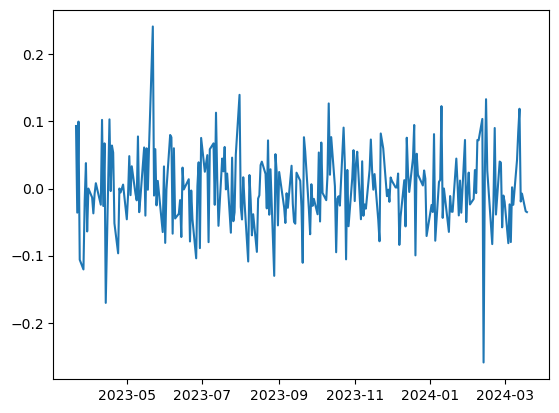

In [39]:
plt.plot(returns_df)

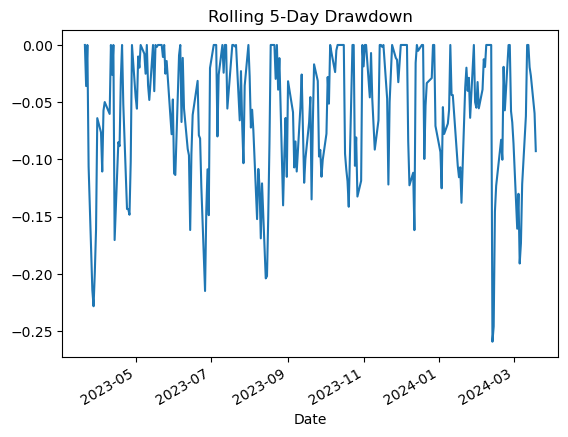

In [40]:
#Drawdown observed over the sample period
rolling_drawdown = metrics.rolling_drawdown()
rolling_drawdown.plot(title="Rolling 5-Day Drawdown")
plt.show()

In [41]:
#Caclculating current momentum factor
#This istance iniciates a class for time series momentum
ts_momentum = TimeSeriesMomentum(returns_df)
#Calculating a simplified version momentum in line with 'Trend Following: Equity and Bond Crisis Alpha' by CARL HAMILL, SANDY RATTRAY and OTTO VAN HEMERT

momentum_t = ts_momentum.momentum_factor()
scaled_momentum_t = ts_momentum.scaler(momentum_t)
cap_scaled_momentum_t = ts_momentum.winzor_range(scaled_momentum_t)
print("Current momentum factor:" + str(round(cap_scaled_momentum_t.iloc[-1,0],2)))


Current momentum factor:0.63


In [13]:
#IMPLEMENT MOMENUTM FROM TREND FOLLOWING PAPER: Get momentum over the past 4 months, and divide that into 4 equal weights. Momentum should be scaled
# by the monthly volatility of returns observed at time t-1. In the scalling process, the estimated standard deviation is multiplied by the square root
# of the weights of each lag. This is done to give the factor a unit standard deviation.
# NOTE: volatilities are also given weights. They are exponentially decaying. This is not the priority now. The important thing is to get monthly volatitlities
# and to make sure that older volatiliyies have lower weight than more recent ones.
#NOTE: AFTER RE READING THE PAPER, I THING THE VOLATILITY STAYS AS THE OBSERVED ONE MONTH VOLATILITY AT TIME T-1!!!